In [1]:
import sys
sys.path.insert(0, "../../..")
from paths import DATA_DIR, FIG_DIR

import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

from graphvelo.graph_velocity import GraphVelo
from graphvelo.utils import mack_score, adj_to_knn
from graphvelo.plot import gene_score_histogram, plot_velocity_phase

In [2]:
scv.settings.verbosity = 3
scv.settings.figdir = str(FIG_DIR)
scv.settings.set_figure_params('scvelo', dpi_save=300, dpi=80, transparent=True, fontsize=20)
scv.settings.plot_prefix = ""

In [3]:
save_figure = True

In [4]:
adata = scv.datasets.gastrulation_erythroid(DATA_DIR / "erythroid_lineage.h5ad")
adata

AnnData object with n_obs × n_vars = 9815 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [4]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/opt/anaconda3/envs/gv-reprod/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode="dynamical")
scv.tl.latent_time(adata)
scv.tl.velocity_graph(adata)

recovering dynamics (using 8/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:01:15) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 3 regions of root cells and 2 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)
computing velocity graph (using 1/10 cores)
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine co

In [ ]:
# adata.write('mouse_ery_pp.h5ad')

In [6]:
adata = sc.read('mouse_ery_pp.h5ad')
adata

AnnData object with n_obs × n_vars = 9815 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'celltype_colors', 'log1p', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'spliced', 'unspliced', 've

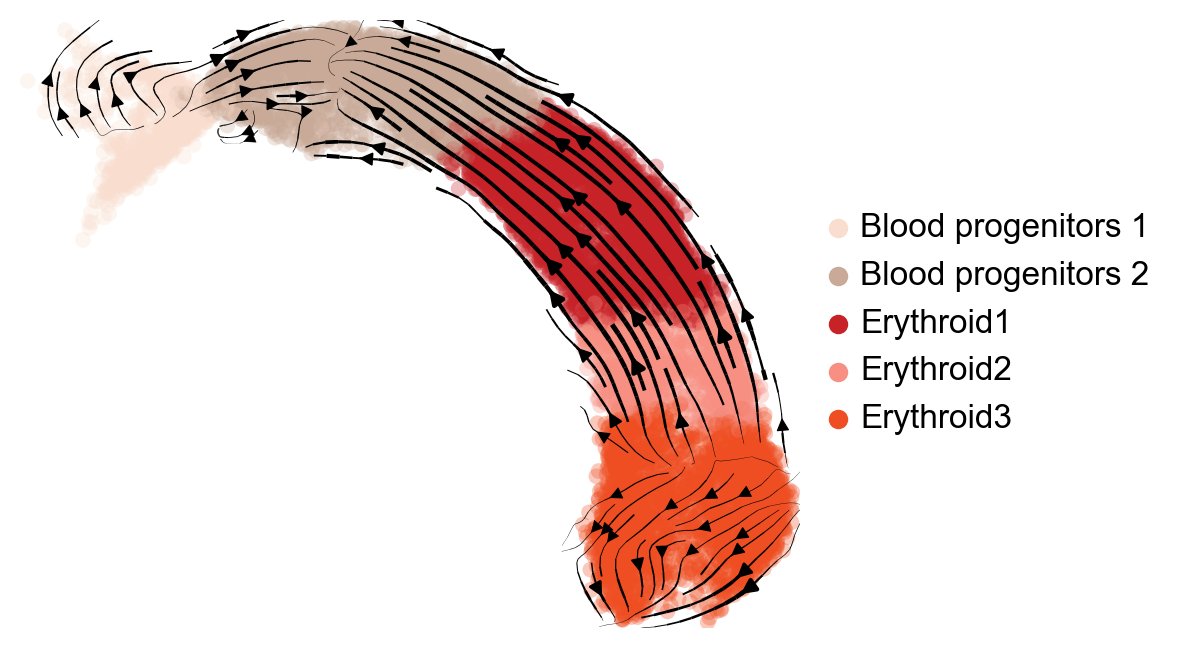

In [7]:
fig_kwargs = {'color': ['celltype'],
                 'legend_loc': 'right', 'dpi': 100, 'title': '', 'figsize': (5,4), 'legend_fontsize': 12}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_mouse_ery/velocities_umap_streamlines.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

## MURK gene velocity in phase diagram

In [8]:
selected_murk = ['Smim1', 'Hba-x']

Plotting velocity in phase diagram: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


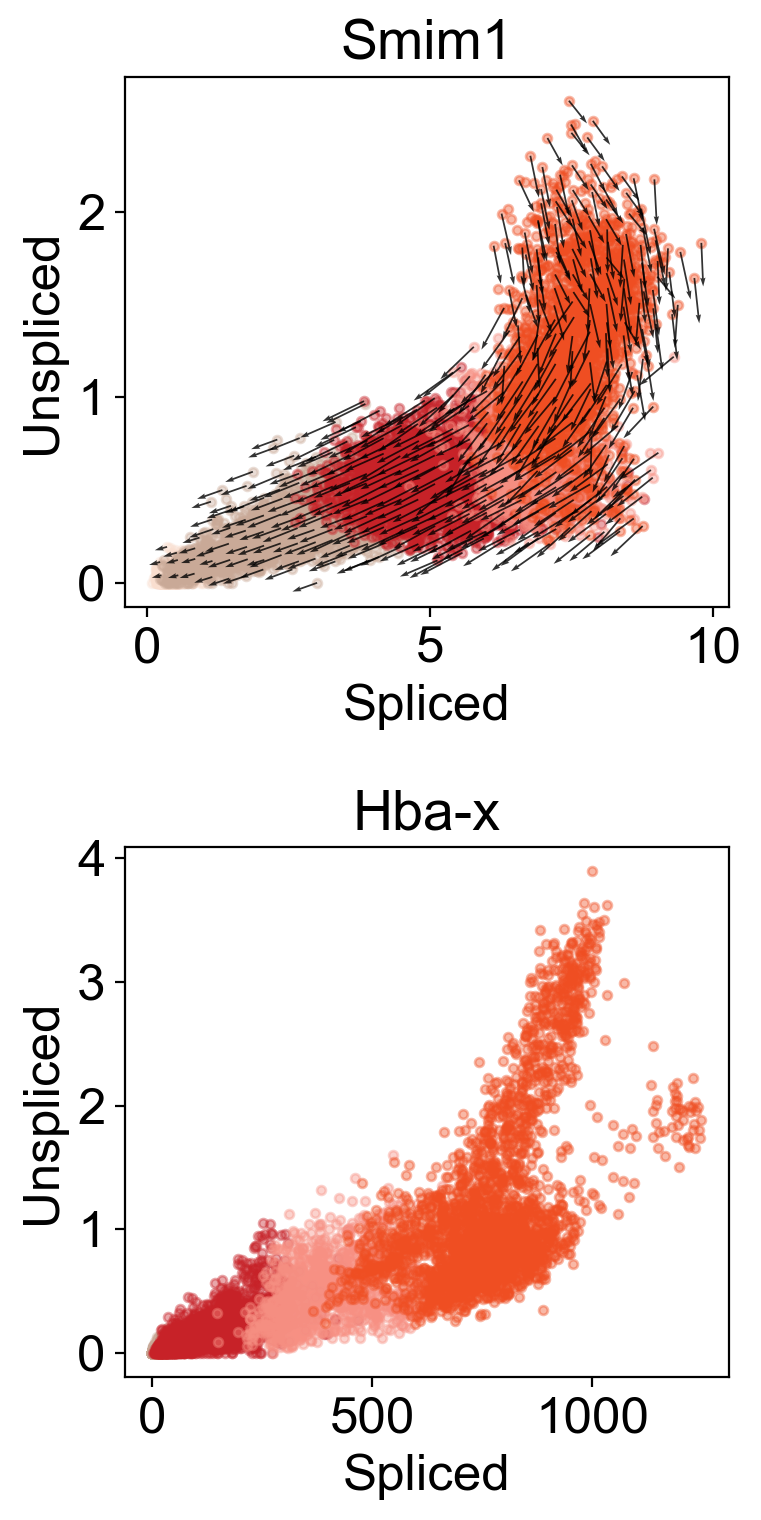

In [9]:
kwargs = {'genes': selected_murk, 'color': 'celltype', 's_layer': 'Ms', 'u_layer': 'Mu', 'vs_layer': 'velocity', 'vu_layer': 'velocity_u', 
          'pointsize': 10, 'ncols': 1, 'scale': 1, 'downsample': 0.1, 'quiver_alpha': 0.8, 'figsize': (4.2, 8), 'show': False}
ax = plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/murk_scv_phase.pdf', dpi=300, transparent=True)
plt.show()

In [10]:
indices, _ = adj_to_knn(adata.obsp['connectivities'])
adata.uns['neighbors']['indices'] = indices

In [11]:
mack_score(adata, ekey='Ms', vkey='velocity', tkey='latent_time', n_jobs=8)

calculating manifold-consistent scores in 8 cpu(s): 100%|██████████| 568/568 [01:00<00:00,  9.43it/s]


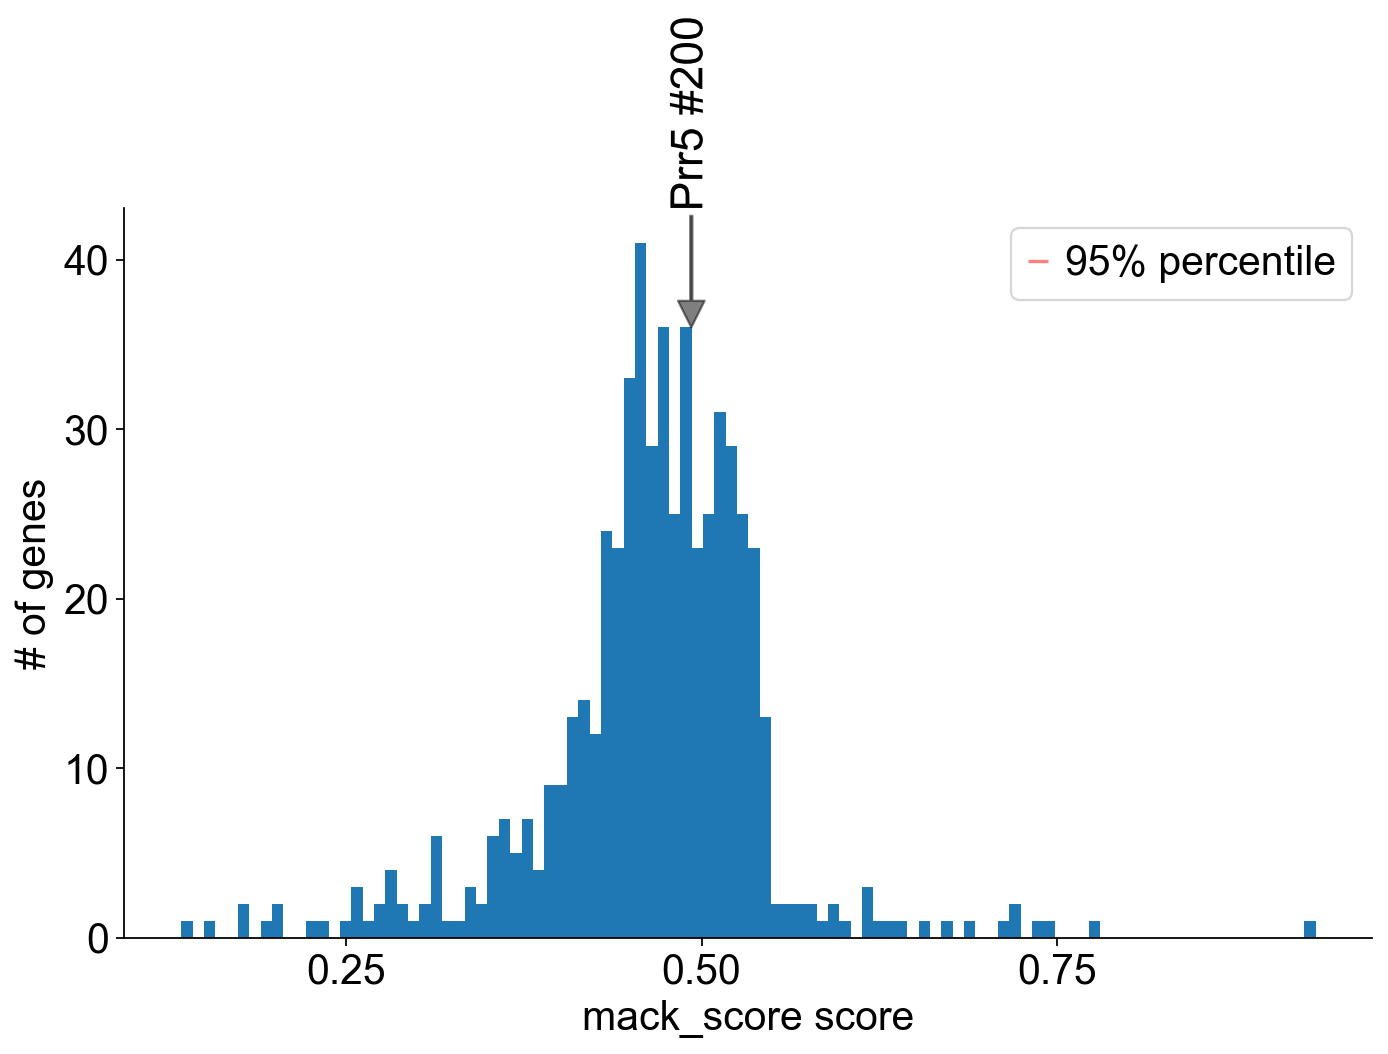

In [12]:
macKG = adata.var['mack_score'].sort_values(ascending=False)[:200].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG[-1]], score_key='mack_score')
plt.show()

Learning Phi in tangent space projection.: 100%|██████████| 9815/9815 [00:06<00:00, 1522.64it/s]


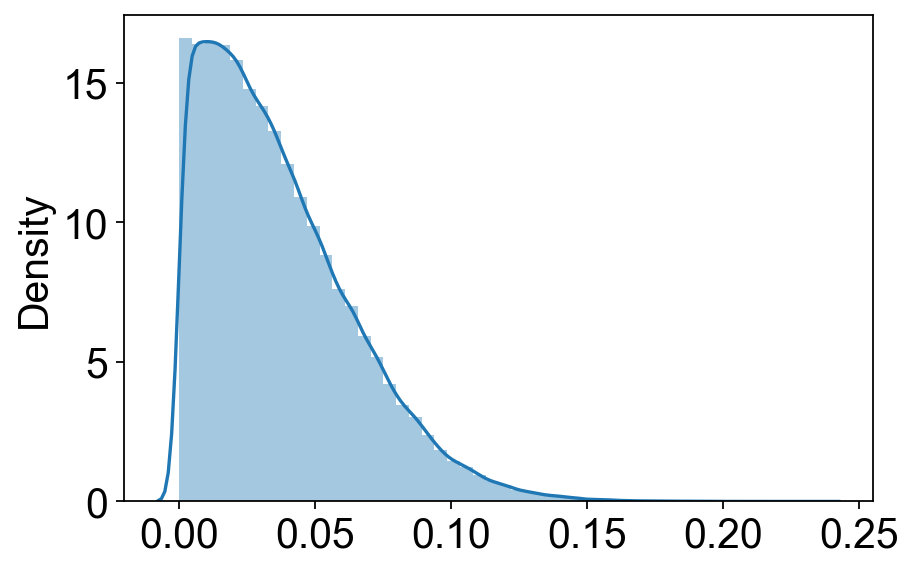

In [13]:
gv = GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [14]:
adata.layers['velocity_gvs'] = gv.project_velocity(adata.layers['Ms'])
adata.layers['velocity_gvu'] = gv.project_velocity(adata.layers['Mu'])
adata.obsm['gv_pca'] = gv.project_velocity(adata.obsm['X_pca'])
adata.obsm['gv_umap'] = gv.project_velocity(adata.obsm['X_umap'])

projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:02<00:00, 3354.98it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:03<00:00, 2924.32it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:00<00:00, 16370.09it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 9815/9815 [00:00<00:00, 18543.01it/s]


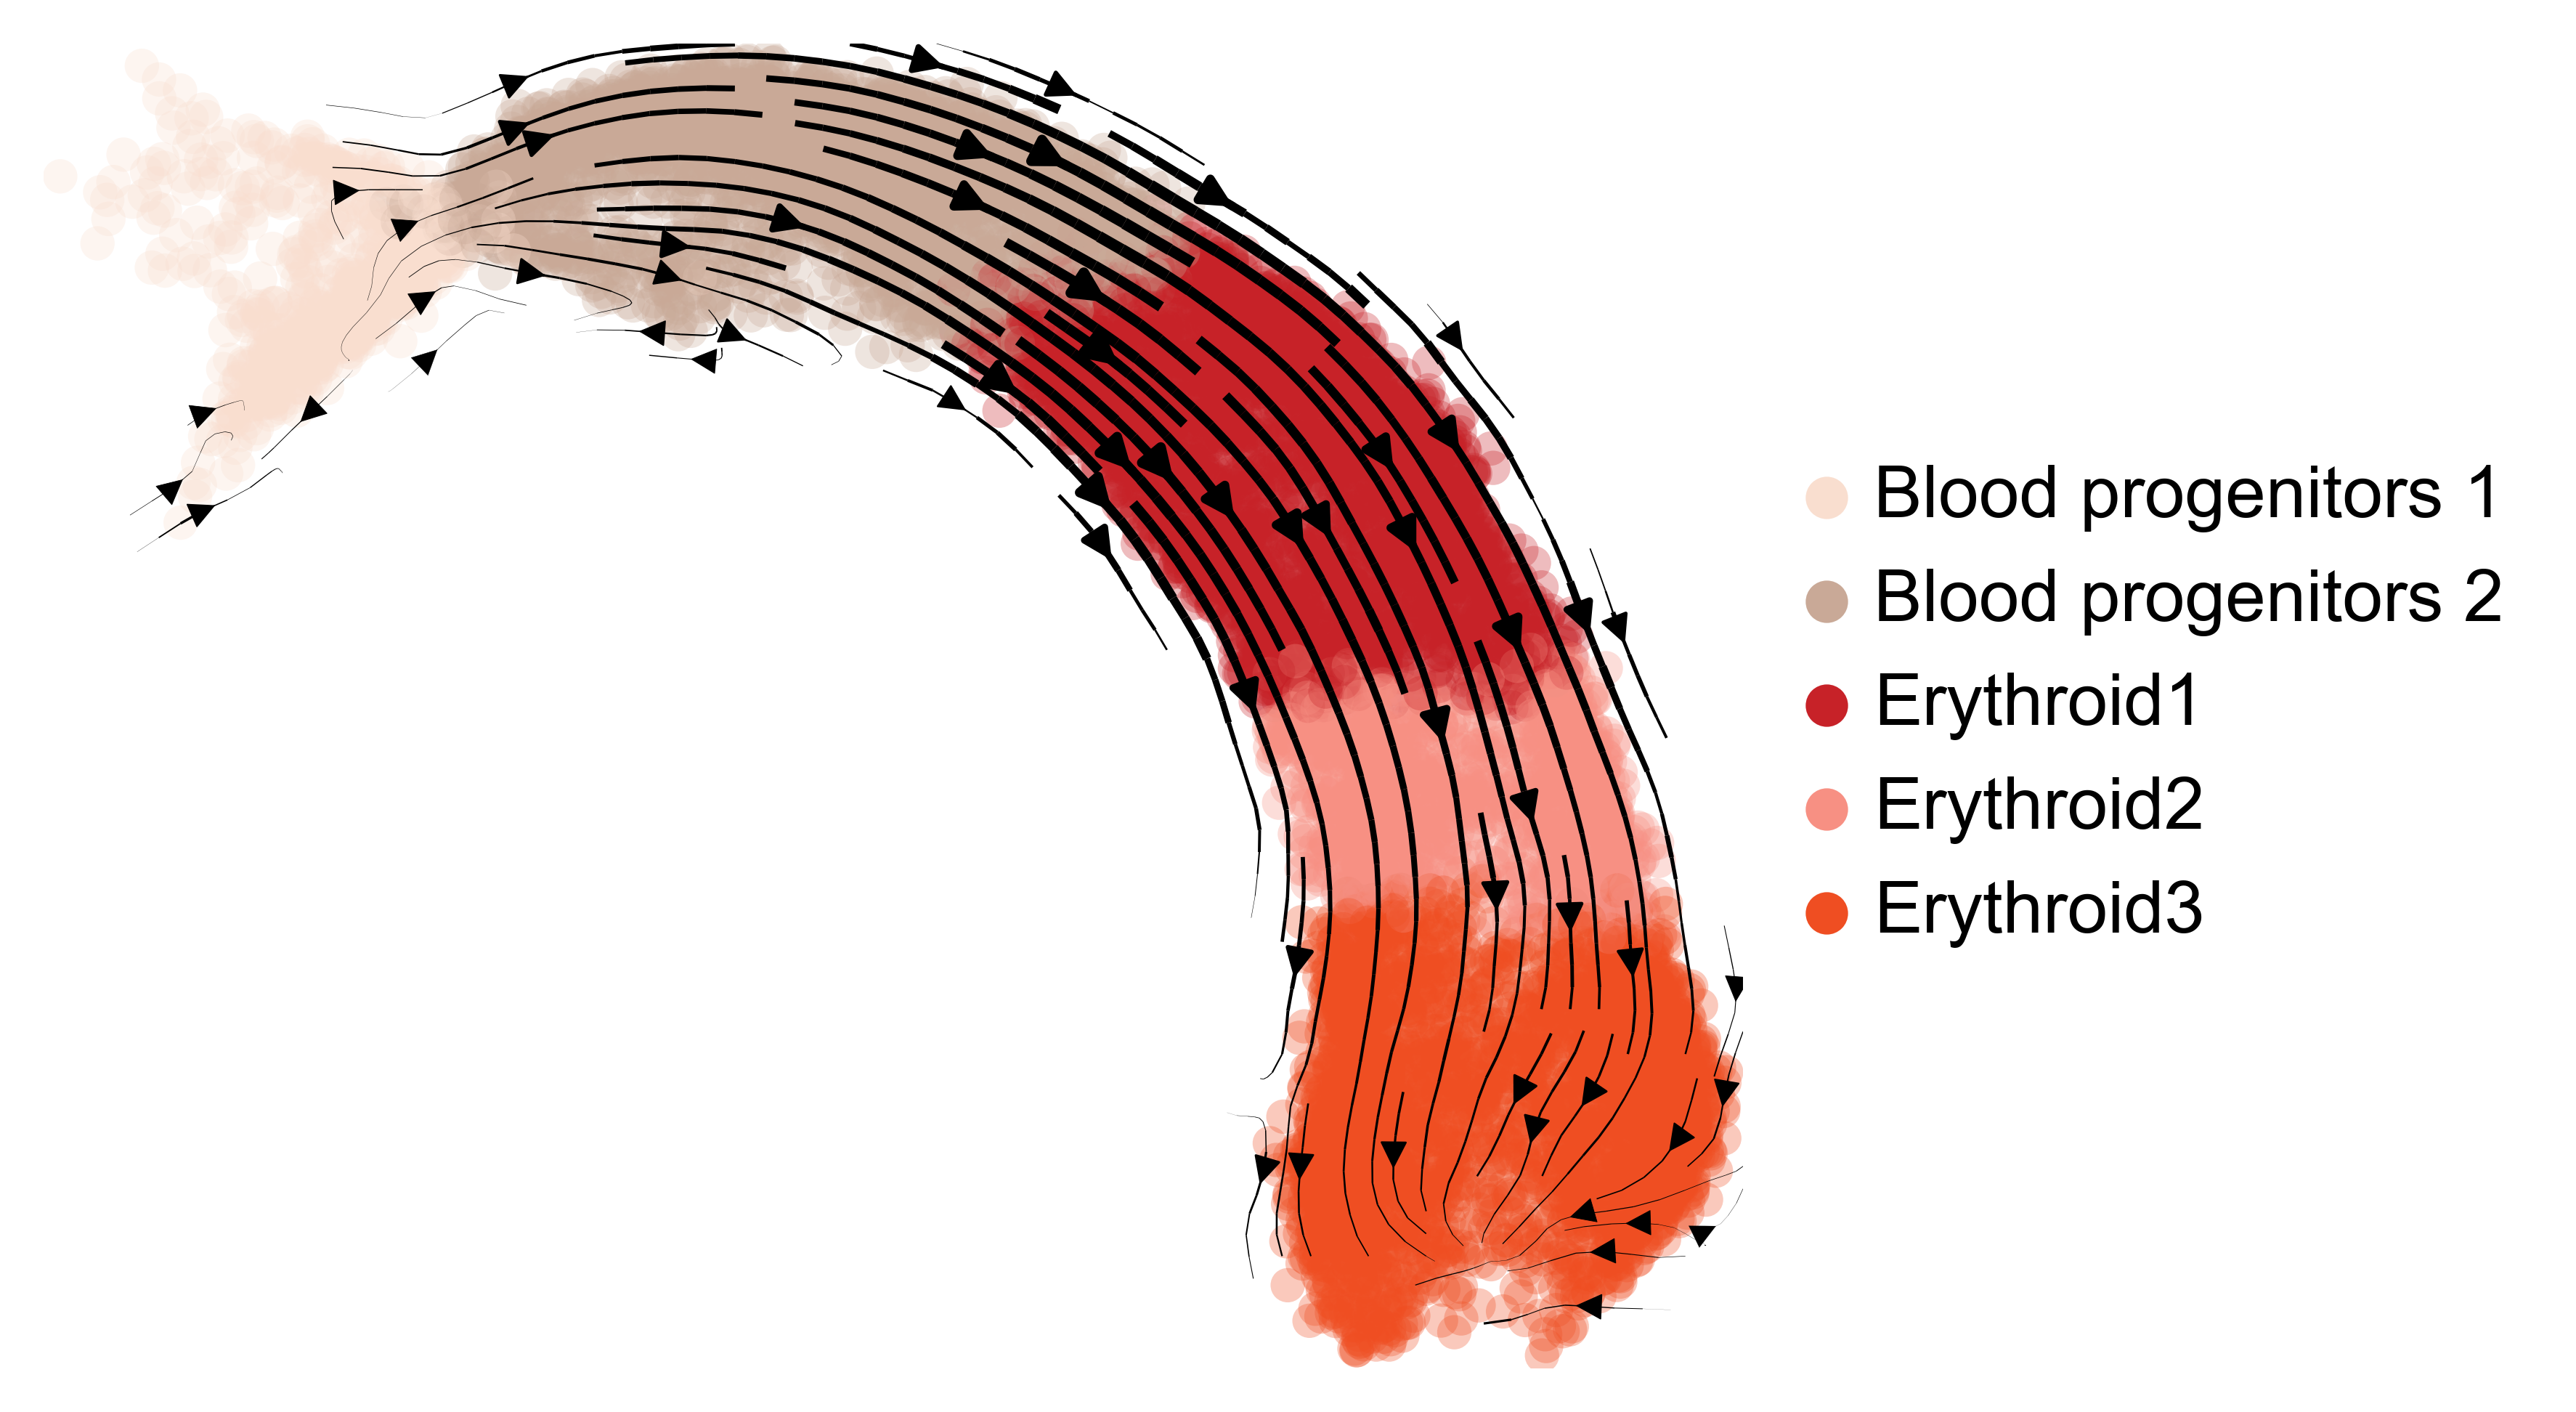

In [15]:
fig_kwargs = {'color': ['celltype'], 'X': adata.obsm['X_umap'], 'V': adata.obsm['gv_umap'],
                 'legend_loc': 'right', 'dpi': 300, 'title': '', 'legend_fontsize': 12, 'figsize': (5,4)}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_mouse_ery/gv_result.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

Plotting velocity in phase diagram: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


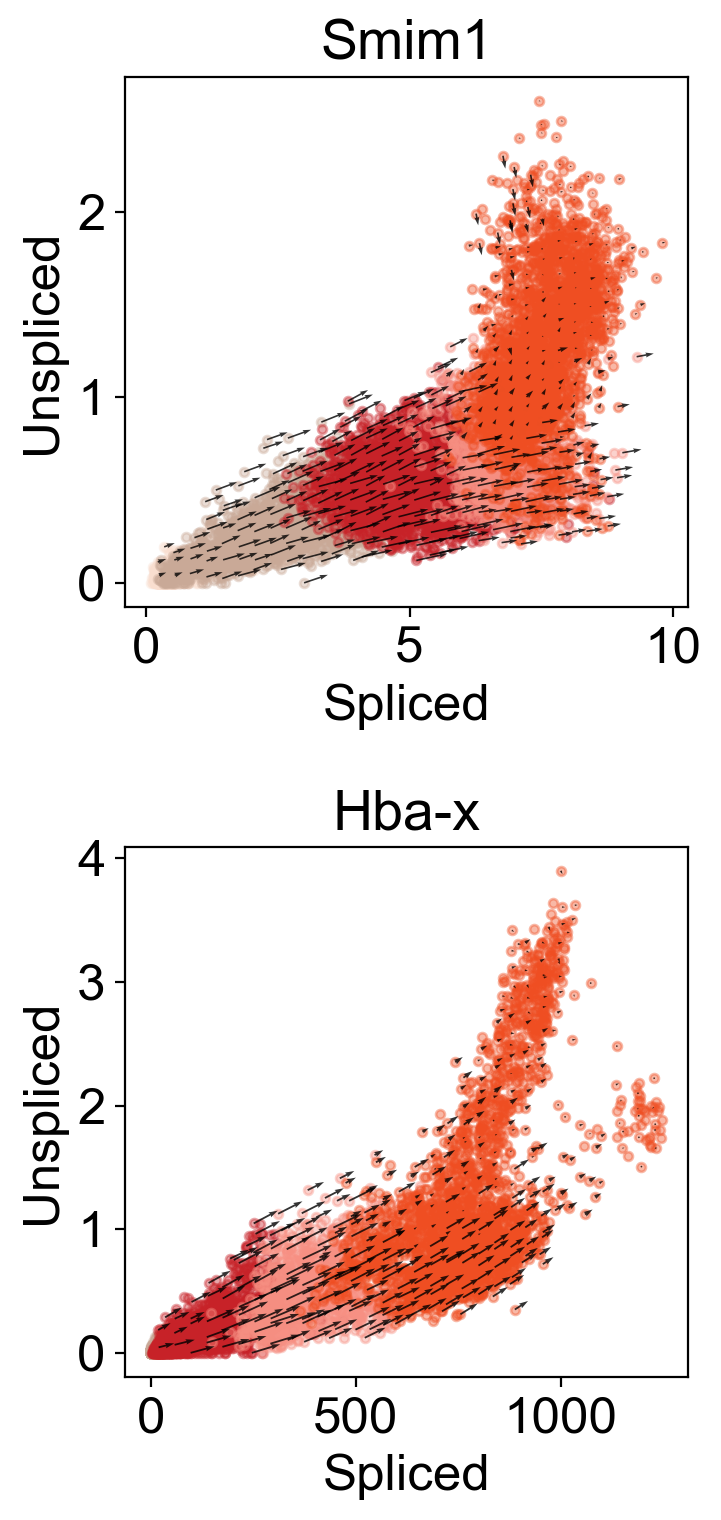

In [16]:
kwargs = {'genes': selected_murk, 'color': 'celltype', 's_layer': 'Ms', 'u_layer': 'Mu', 'vs_layer': 'velocity_gvs', 'vu_layer': 'velocity_gvu', 
          'pointsize': 10, 'ncols': 1, 'scale': 1, 'downsample': 0.1, 'quiver_alpha': 0.8, 'figsize': (4, 8), 'show': False}
ax = plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/murk_gv200_phase.pdf', dpi=300, transparent=True)
plt.show()